In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import matplotlib.path as mpath
import scipy.io
import matplotlib.gridspec as gridspec

# functions from gasex module
from gasex.phys import vpress_sw
from gasex.fugacity import fugacity_factor

In [3]:
# make plots look nice
sns.set_context("talk", rc = {"lines.linewidth":2.5})

In [4]:
# helper function
def generateinputs(tests, windproduct):
    parameterizations = ["W14", "L13"]
    #windproducts = ["ncep"]    
    inputs = [[p,w, t] for p in parameterizations for w in windproduct for t in tests]
    print(f"inputs: {inputs}")
    return inputs

# LOAD DATA FOR FIGURES 1, 4, & 5

In [5]:
outputpath = 'datasets'
t = pq.read_table(f"{outputpath}/n2opredictions.parquet")
data = t.to_pandas()

data["msl"] = data[["msl_era5", "msl_ncep"]].mean(axis = 1)
data["U10"] = data[["U10_era5","U10_ncep"]].mean(axis = 1)
data["SI"] = data.SI_era5

# constants for converting umol/m2/day to Tg N2O-N/year
Ngpermol = 14.0067
Tgperg = 1e12
umolpermol = 1e6

# properties needed for area-time integration
areas = pd.DataFrame([["STZ",2.26e7],["SAZ",1.94e7],["PFZ",1.43e7],
                           ["ASZ",1.28e7],["SIZ",1.72e7],["TOTAL",8.64e7]],
                columns = ["zone","Area_km2"]).set_index("zone")

areas["m2"] = areas.Area_km2*1e6 # convert to m2 because fluxes are in umol/m2/day

daysinmonth = pd.DataFrame([[1.0, 31],
                            [2.0,28],
                            [3.0,31],
                            [4.0,30],
                            [5.0,31],
                            [6.0,30],
                            [7.0, 31],
                            [8.0,31],
                            [9.0,30],
                            [10.0,31],
                            [11.0,30],
                            [12.0,31],
                           ],
                           columns = ["month","daysinmonth"]).set_index("month")
Ft = np.load(f"{outputpath}/fluxtests/observedcombined_mean.npy")
Ftstdev = np.load(f"{outputpath}/fluxtests/observedcombined_stdev.npy")

data["Ft"] = Ft
data["Ftstdev"] = Ftstdev

condition = "observed"
inputs = generateinputs([condition], ["ncep", "era5"])
labels = []

for test in inputs:
    p = test[0]
    t = test[2]
    w = test[1]
    
    Ft = np.load(f"{outputpath}/fluxtests/{t}{w}{p}_mean.npy")
    Ftstdev = np.load(f"{outputpath}/fluxtests/{test[2]}{test[1]}{test[0]}_stdev.npy")
    
    meanlabel = f"{t}{w}{p}"
    stdevlabel = f"{t}{w}{p}_stdev"

    print(meanlabel, stdevlabel)
    labels.append(meanlabel)

    data[meanlabel] = Ft
    data[stdevlabel] = Ftstdev

data["Ft"] = np.load(f'{outputpath}/fluxtests/{condition}combined_mean.npy')
data["pN2O_uncertainty"] = np.load(f'{outputpath}/fluxtests/{condition}combined_stdev.npy')
data["wind_uncertainty"] = data[labels].std(axis=1)
data["Ftstdev"] = np.sqrt(data["pN2O_uncertainty"]**2 + data["wind_uncertainty"]**2)

tests = ["baseline", "noice", "1atm", "medmsl", "meanmsl", "medK", "meanK", "medN2O",
    "meanN2O", # for whatever reason, this one throws an error
    "WINDS", "COMBINED", "CYCLONES"
    ]
for condition in tests:
    inputs = generateinputs([condition], ["ncep", "era5"])
    labels = []
    
    for test in inputs:
        p = test[0]
        t = test[2]
        w = test[1]
        
        Ft = np.load(f"{outputpath}/fluxtests/{t}{w}{p}_mean.npy")
        Ftstdev = np.load(f"{outputpath}/fluxtests/{test[2]}{test[1]}{test[0]}_stdev.npy")
        
        meanlabel = f"{t}{w}{p}"
        stdevlabel = f"{t}{w}{p}_stdev"
    
        print(meanlabel, stdevlabel)
        labels.append(meanlabel)
    
        data[meanlabel] = Ft
        data[stdevlabel] = Ftstdev
    
    data[f"Ft{condition}"] = np.load(f'{outputpath}/fluxtests/{condition}combined_mean.npy')
    pN2O_uncertainty_condition = np.load(f'{outputpath}/fluxtests/{condition}combined_stdev.npy')
    wind_uncertainty_condition = data[labels].std(axis=1)
    data[f"Ft{condition}stdev"] = np.sqrt(pN2O_uncertainty_condition**2 + wind_uncertainty_condition**2)

data = data.copy() # avoid fragmenting dataframe

ph2ov = vpress_sw(data.SP,data.pt) # atm
f  = fugacity_factor(data.pt, gas='N2O',slp=data.msl)
data["pN2Oatm"] = data.XN2Oa*1e9 * f * (data.msl - ph2ov)
data["pN2Oatm_1atm"] = data.XN2Oa*1e9 * f * (1 - ph2ov)
data["DpN2O_pred"] = data.pN2O_pred -data["pN2Oatm"]
data["DpN2O_pred2"] = data.pN2O_pred -data["pN2Oatm_1atm"]
data["DpN2O_pred3"] = np.median(data.pN2O_pred) - data["pN2Oatm"]

data.to_csv('datasets/fig1fig4fig5.csv')

inputs: [['W14', 'ncep', 'observed'], ['W14', 'era5', 'observed'], ['L13', 'ncep', 'observed'], ['L13', 'era5', 'observed']]
observedncepW14 observedncepW14_stdev
observedera5W14 observedera5W14_stdev
observedncepL13 observedncepL13_stdev
observedera5L13 observedera5L13_stdev
inputs: [['W14', 'ncep', 'baseline'], ['W14', 'era5', 'baseline'], ['L13', 'ncep', 'baseline'], ['L13', 'era5', 'baseline']]
baselinencepW14 baselinencepW14_stdev
baselineera5W14 baselineera5W14_stdev
baselinencepL13 baselinencepL13_stdev
baselineera5L13 baselineera5L13_stdev
inputs: [['W14', 'ncep', 'noice'], ['W14', 'era5', 'noice'], ['L13', 'ncep', 'noice'], ['L13', 'era5', 'noice']]
noicencepW14 noicencepW14_stdev
noiceera5W14 noiceera5W14_stdev
noicencepL13 noicencepL13_stdev
noiceera5L13 noiceera5L13_stdev
inputs: [['W14', 'ncep', '1atm'], ['W14', 'era5', '1atm'], ['L13', 'ncep', '1atm'], ['L13', 'era5', '1atm']]
1atmncepW14 1atmncepW14_stdev
1atmera5W14 1atmera5W14_stdev
1atmncepL13 1atmncepL13_stdev
1atmer

/tmp/ipykernel_145482/909589351.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[meanlabel] = Ft
/tmp/ipykernel_145482/909589351.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stdevlabel] = Ftstdev
/tmp/ipykernel_145482/909589351.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


WINDSncepW14 WINDSncepW14_stdev
WINDSera5W14 WINDSera5W14_stdev
WINDSncepL13 WINDSncepL13_stdev
WINDSera5L13 WINDSera5L13_stdev
inputs: [['W14', 'ncep', 'COMBINED'], ['W14', 'era5', 'COMBINED'], ['L13', 'ncep', 'COMBINED'], ['L13', 'era5', 'COMBINED']]


/tmp/ipykernel_145482/909589351.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[meanlabel] = Ft
/tmp/ipykernel_145482/909589351.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stdevlabel] = Ftstdev
/tmp/ipykernel_145482/909589351.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


COMBINEDncepW14 COMBINEDncepW14_stdev
COMBINEDera5W14 COMBINEDera5W14_stdev
COMBINEDncepL13 COMBINEDncepL13_stdev
COMBINEDera5L13 COMBINEDera5L13_stdev
inputs: [['W14', 'ncep', 'CYCLONES'], ['W14', 'era5', 'CYCLONES'], ['L13', 'ncep', 'CYCLONES'], ['L13', 'era5', 'CYCLONES']]


/tmp/ipykernel_145482/909589351.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[meanlabel] = Ft
/tmp/ipykernel_145482/909589351.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stdevlabel] = Ftstdev
/tmp/ipykernel_145482/909589351.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


CYCLONESncepW14 CYCLONESncepW14_stdev
CYCLONESera5W14 CYCLONESera5W14_stdev
CYCLONESncepL13 CYCLONESncepL13_stdev
CYCLONESera5L13 CYCLONESera5L13_stdev


/tmp/ipykernel_145482/909589351.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[meanlabel] = Ft
/tmp/ipykernel_145482/909589351.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stdevlabel] = Ftstdev
/tmp/ipykernel_145482/909589351.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


# FIGURE 1

In [6]:
# load fronts from Gray et al.
mat = scipy.io.loadmat('datasets/fronts_Gray.mat')
lat_pf=mat['lat_pf'][0] #Polar Front
lon_pf=mat['lon_pf'][0] #Polar Front
lat_siz=mat['lat_siz'][0] #Seasonal Ice Zone
lon_siz=mat['lon_siz'][0] #Seasonal Ice Zone
lat_saf=mat['lat_saf'][0] #Subantarctic Front
lon_saf=mat['lon_saf'][0] #Subantarctic Front
lat_stf=mat['lat_stf'][0] #Subtropical Front
lon_stf=mat['lon_stf'][0] #Subtropical Front

In [7]:
def plotfronts(ax):
    ax.plot(lon_pf[0:1409],lat_pf[0:1409],c="k",lw=2,zorder=4,transform=ccrs.PlateCarree())
    ax.plot(lon_pf[1410:len(lon_pf)],lat_pf[1410:len(lon_pf)],c="k",lw=2,zorder=4,transform=ccrs.PlateCarree())
    ax.plot(lon_siz[0:537],lat_siz[0:537],c="k",lw=2,zorder=4,transform=ccrs.PlateCarree())
    ax.plot(lon_siz[538:len(lon_siz)],lat_siz[538:len(lon_siz)],c="k",lw=2,zorder=4,transform=ccrs.PlateCarree())
    ax.plot(lon_saf[0:2016],lat_saf[0:2016],c="k",lw=2,zorder=4,transform=ccrs.PlateCarree())
    ax.plot(lon_saf[2017:2911],lat_saf[2017:2911],c="k",lw=2,zorder=4,transform=ccrs.PlateCarree())
    ax.plot(lon_stf[0:1871],lat_stf[0:1871],c="k",lw=2,zorder=4,transform=ccrs.PlateCarree())
    ax.plot(lon_stf[1872:len(lon_stf)],lat_stf[1872:len(lon_stf)],c="k",lw=2,zorder=4,transform=ccrs.PlateCarree())

def setupmap(ax):
    ax.set_extent([-180, 180, -90, -30], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND,facecolor='gray',zorder=4)
    #g = ax.gridlines(linestyle='--',zorder=5, draw_labels=False)
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    import matplotlib.path as mpath
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cfeature.OCEAN, facecolor='lightskyblue')

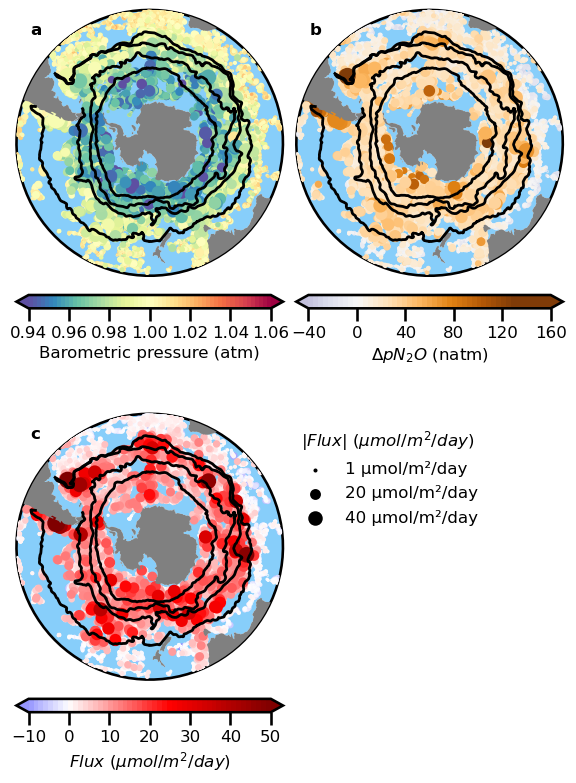

In [9]:
data = pd.read_csv('datasets/fig1fig4fig5.csv')

fig = plt.figure(figsize=(7.05, 10.24))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], wspace=0.05, hspace=0.05)

### SUBPLOT 1 ###
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.SouthPolarStereo())
ax1.text(0.05, 0.95, "a", fontweight="bold",
        horizontalalignment = "left",
        verticalalignment = "top",
        transform = ax1.transAxes,
        fontsize = 12)
setupmap(ax1)
param = "msl"
label = r'Barometric pressure (atm)'
surface = data.sort_values("Ft", ascending = True)
colormap = 'Spectral_r'
msllevs = np.arange(0.94,1.06,0.002)

cax1 = plt.scatter(x=surface["LONGITUDE"],y=surface["LATITUDE"],
                  c=surface[param],
                  s=np.abs(surface["Ft"])*2,
                  zorder=3,
                  vmin=0.94, vmax=1.06,
                  label = None,
                  transform=ccrs.PlateCarree(),
                 cmap = colormap)

# plot fronts
plotfronts(ax1)

bounds=msllevs
cbar1 = fig.colorbar(cax1, ax=ax1, orientation='horizontal', pad=0.05,
                    extend='both', boundaries=bounds,
                    ticks = msllevs[::10])
cbar1.set_label(label, fontsize = 12)
cbar1.ax.tick_params(labelsize = 12)

### SUBPLOT 2 ###
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.SouthPolarStereo())
ax2.text(0.05, 0.95, "b", fontweight="bold",
        horizontalalignment = "left",
        verticalalignment = "top",
        transform = ax2.transAxes,
        fontsize = 12)
setupmap(ax2)

param = "DpN2O_pred"
label = r'$\Delta pN_2O$ (natm)'
surface = data.sort_values("Ft", ascending = True)

cax2 = plt.scatter(x=surface["LONGITUDE"],y=surface["LATITUDE"],
                  c=surface[param],
                  s=np.abs(surface["Ft"])*2,
                  zorder=3,
                  vmin = -130, vmax = 130,
                  label = None,
                  transform=ccrs.PlateCarree(),
                 cmap = 'PuOr_r')

# plot fronts
plotfronts(ax2)

bounds=np.linspace(-40,160) #[i for i in np.arange(-40,200,40)]
cbar2 = fig.colorbar(cax2, ax=ax2, orientation='horizontal', pad=0.05,
                    extend='both', boundaries=bounds,
                    ticks = [i for i in np.arange(-40,200,40)])
cbar2.set_label(label, fontsize = 12)
cbar2.ax.tick_params(labelsize = 12)

### SUBPLOT 3 ###
ax3 = fig.add_subplot(gs[1, 0], projection=ccrs.SouthPolarStereo())
ax3.text(0.05, 0.95, "c", fontweight="bold",
        horizontalalignment = "left",
        verticalalignment = "top",
        transform = ax3.transAxes,
        fontsize = 12)
setupmap(ax3)
param = "Ft"
label = r'$Flux\ (\mu mol/m^2/day)$'
surface = data.sort_values("Ft", ascending = True)

cax3 = plt.scatter(x=surface["LONGITUDE"],y=surface["LATITUDE"],
                  c=surface[param],
                  s=np.abs(surface["Ft"])*2,
                  zorder=3,
                  vmax = 50, vmin = -50,
                  label = None,
                  transform=ccrs.PlateCarree(),
                 cmap = 'seismic')

# plot fronts
plotfronts(ax3)

bounds=np.linspace(-10,50) #[i for i in np.arange(-10,60,10)]
cbar3 = fig.colorbar(cax3, ax=ax3, orientation='horizontal', pad=0.05,
                    extend='both', boundaries=bounds,
                    ticks = [i for i in np.arange(-10,60,10)])
cbar3.set_label(label, fontsize = 12)
cbar3.ax.tick_params(labelsize = 12)

# dot size legend
flux_legend_values = [1, 20, 40]  # Example flux values (change to your specific range)
legend_labels = [f"{val} µmol/m²/day" for val in flux_legend_values]
legend_handles = [plt.scatter([], [], s=val*2, color='k', label=label)
                  for val, label in zip(flux_legend_values, legend_labels)]

ax3.legend(handles=legend_handles,title="$|Flux|\ (\mu mol/m^2/day)$",
           bbox_to_anchor=(1,1), loc='upper left', framealpha = 0.0,
          fontsize=12, title_fontsize=12)

plt.savefig("figures/figure1.pdf", bbox_inches = "tight")

plt.show()

# FIGURE 2

In [17]:
outputpath = 'datasets'
t = pq.read_table(f"{outputpath}/n2opredictions.parquet")
surface = t.to_pandas()

inputs = generateinputs(["observed"], ["ncep", "era5"])

for test in inputs:
    p = test[0]
    t = test[2]
    w = test[1]
    
    Ft = np.load(f"{outputpath}/fluxtests/{t}{w}{p}_mean.npy")
    Ftstdev = np.load(f"{outputpath}/fluxtests/{test[2]}{test[1]}{test[0]}_stdev.npy")
    
    meanlabel = f"{t}{w}{p}"
    stdevlabel = f"{t}{w}{p}_stdev"

    surface[meanlabel] = Ft*surface.m2*surface.daysinmonth/surface.msl_era5count*(Ngpermol*2)/Tgperg/umolpermol
    surface[stdevlabel] = Ftstdev*surface.m2*surface.daysinmonth/surface.msl_era5count*(Ngpermol*2)/Tgperg/umolpermol

surface["combined_mean"] = np.load(f'{outputpath}/fluxtests/{"observed"}combined_mean.npy')*surface.m2*surface.daysinmonth/surface.msl_era5count*(Ngpermol*2)/Tgperg/umolpermol
surface["combined_uncertainty"] = np.load(f'{outputpath}/fluxtests/{"observed"}combined_stdev.npy')*surface.m2*surface.daysinmonth/surface.msl_era5count*(Ngpermol*2)/Tgperg/umolpermol

data_sorted = surface.sort_values(f"msl_era5")

mean_cumsum = np.cumsum(np.array(data_sorted["combined_mean"]))
mslarray = np.array(data_sorted[f"msl_era5"])

print(mean_cumsum[-1])
cumsums = np.empty((len(data_sorted),len(inputs)))

for count, test in enumerate(inputs):
    p = test[0]
    t = test[2]
    w = test[1]

    cumsum = np.cumsum(np.array(data_sorted[f"{t}{w}{p}"]))
    cumsums[:,count] = cumsum

    uncertainties = np.array(data_sorted[f"{t}{w}{p}_stdev"])
    uncertaintiessquared = uncertainties**2
    uncertaintiescumulative = np.cumsum(uncertaintiessquared)
    uncertainties = np.sqrt(uncertaintiescumulative)

wind_uncertainty = np.std(cumsums, axis = 1)

montecarlo_uncertainty = np.cumsum(np.array(data_sorted["combined_uncertainty"])**2)

bootstrap_uncertainty = 0.038*mean_cumsum#bootstrap_uncertainties[260]/np.mean(bootstrap_sums[260,:])*mean_cumsum

total_uncertainty = np.sqrt(
    wind_uncertainty**2 + 
    montecarlo_uncertainty + 
    bootstrap_uncertainty**2
)

data_sorted["mslarray"] = mslarray
data_sorted["mean_cumsum"] = mean_cumsum
data_sorted["wind_uncertainty"] = wind_uncertainty
data_sorted["montecarlo_uncertainty"] = montecarlo_uncertainty
data_sorted["bootstrap_uncertainty"] = bootstrap_uncertainty
data_sorted["total_uncertainty"] = total_uncertainty
data_sorted.to_csv("datasets/fig2a.csv")

inputs: [['W14', 'ncep', 'observed'], ['W14', 'era5', 'observed'], ['L13', 'ncep', 'observed'], ['L13', 'era5', 'observed']]
1.5954010434742338


In [18]:
outputpath = 'datasets'
t = pq.read_table(f"{outputpath}/n2opredictions.parquet")
surface = t.to_pandas()

inputs = generateinputs(["1atm"], ["ncep", "era5"])

for test in inputs:
    p = test[0]
    t = test[2]
    w = test[1]
    
    Ft = np.load(f"{outputpath}/fluxtests/{t}{w}{p}_mean.npy")
    Ftstdev = np.load(f"{outputpath}/fluxtests/{test[2]}{test[1]}{test[0]}_stdev.npy")
    
    meanlabel = f"{t}{w}{p}"
    stdevlabel = f"{t}{w}{p}_stdev"

    surface[meanlabel] = Ft*surface.m2*surface.daysinmonth/surface.msl_era5count*(Ngpermol*2)/Tgperg/umolpermol
    surface[stdevlabel] = Ftstdev*surface.m2*surface.daysinmonth/surface.msl_era5count*(Ngpermol*2)/Tgperg/umolpermol

surface["combined_mean"] = np.load(f'{outputpath}/fluxtests/{"1atm"}combined_mean.npy')*surface.m2*surface.daysinmonth/surface.msl_era5count*(Ngpermol*2)/Tgperg/umolpermol
surface["combined_uncertainty"] = np.load(f'{outputpath}/fluxtests/{"1atm"}combined_stdev.npy')*surface.m2*surface.daysinmonth/surface.msl_era5count*(Ngpermol*2)/Tgperg/umolpermol

data_sorted = surface.sort_values(f"msl_era5")

mean_cumsum = np.cumsum(np.array(data_sorted["combined_mean"]))
mslarray = np.array(data_sorted[f"msl_era5"])

print(mean_cumsum[-1])
cumsums = np.empty((len(data_sorted),len(inputs)))

for count, test in enumerate(inputs):
    p = test[0]
    t = test[2]
    w = test[1]

    cumsum = np.cumsum(np.array(data_sorted[f"{t}{w}{p}"]))
    cumsums[:,count] = cumsum

    uncertainties = np.array(data_sorted[f"{t}{w}{p}_stdev"])
    uncertaintiessquared = uncertainties**2
    uncertaintiescumulative = np.cumsum(uncertaintiessquared)
    uncertainties = np.sqrt(uncertaintiescumulative)

wind_uncertainty = np.std(cumsums, axis = 1)

montecarlo_uncertainty = np.cumsum(np.array(data_sorted["combined_uncertainty"])**2)

bootstrap_uncertainty = 0.038*mean_cumsum#bootstrap_uncertainties[260]/np.mean(bootstrap_sums[260,:])*mean_cumsum

total_uncertainty = np.sqrt(
    wind_uncertainty**2 + 
    montecarlo_uncertainty + 
    bootstrap_uncertainty**2
)

data_sorted["mslarray"] = mslarray
data_sorted["mean_cumsum"] = mean_cumsum
data_sorted["wind_uncertainty"] = wind_uncertainty
data_sorted["montecarlo_uncertainty"] = montecarlo_uncertainty
data_sorted["bootstrap_uncertainty"] = bootstrap_uncertainty
data_sorted["total_uncertainty"] = total_uncertainty
data_sorted.to_csv("datasets/fig2b.csv")

inputs: [['W14', 'ncep', '1atm'], ['W14', 'era5', '1atm'], ['L13', 'ncep', '1atm'], ['L13', 'era5', '1atm']]
0.8929258341553027


inputs: [['W14', 'ncep', 'observed'], ['W14', 'era5', 'observed'], ['L13', 'ncep', 'observed'], ['L13', 'era5', 'observed']]
0.3210364911227036
inputs: [['W14', 'ncep', '1atm'], ['W14', 'era5', '1atm'], ['L13', 'ncep', '1atm'], ['L13', 'era5', '1atm']]
0.8929258341551669
0.3338596365796409


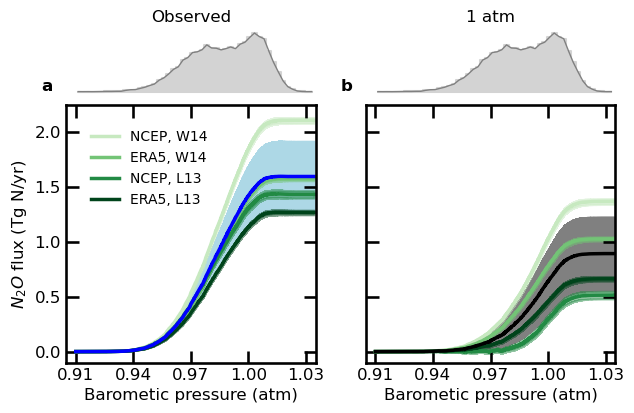

In [20]:
outputpath = 'datasets'

cmap = plt.get_cmap('Greens')
colors = cmap(np.linspace(0.25, 1, len(inputs)))

fig, axes = plt.subplots(1,2, figsize = (7.09, 3.35), sharey=True)

ax = axes[0]
data_sorted = pd.read_csv("datasets/fig2a.csv")
cumsums = np.empty((len(data_sorted),len(inputs)))
inputs = generateinputs(["observed"], ["ncep", "era5"])

for count, test in enumerate(inputs):
    p = test[0]
    t = test[2]
    w = test[1]

    cumsum = np.cumsum(np.array(data_sorted[f"{t}{w}{p}"]))
    cumsums[:,count] = cumsum

    uncertainties = np.array(data_sorted[f"{t}{w}{p}_stdev"])
    uncertaintiessquared = uncertainties**2
    uncertaintiescumulative = np.cumsum(uncertaintiessquared)
    uncertainties = np.sqrt(uncertaintiescumulative)

    mslarray = np.array(data_sorted[f"msl_era5"])

    ax.fill_between(mslarray, (cumsum - uncertainties),
                (cumsum + uncertainties), zorder=1, color = colors[count],
                   alpha = 0.5)
    windlabel = f"{w}".upper()
    ax.plot(mslarray, cumsum, label = f"{windlabel}, {p}", color = colors[count])

wind_uncertainty = np.std(cumsums, axis = 1)

montecarlo_uncertainty = np.cumsum(np.array(data_sorted["combined_uncertainty"])**2)

bootstrap_uncertainty = 0.038*mean_cumsum#bootstrap_uncertainties[260]/np.mean(bootstrap_sums[260,:])*mean_cumsum

total_uncertainty = np.sqrt(
    wind_uncertainty**2 + 
    montecarlo_uncertainty + 
    bootstrap_uncertainty**2
)
mslarray= np.array(data_sorted["mslarray"])
mean_cumsum = np.array(data_sorted["mean_cumsum"])
total_uncertainty = np.array(data_sorted["total_uncertainty"])

ax.fill_between(mslarray, (mean_cumsum - total_uncertainty),
                (mean_cumsum + total_uncertainty), color = "lightblue", zorder=0)
ax.plot(mslarray, mean_cumsum, color = "b", label = None)
print(total_uncertainty[-1])

ax.legend(framealpha = 0, bbox_to_anchor=(0.05,0.95), loc = "upper left", fontsize = 10)
ax.set_ylabel(r"$N_2O$ flux (Tg N/yr)", fontsize = 12)
ax.set_xlabel("Barometic pressure (atm)", fontsize = 12)
ax.set_xlim([0.905, 1.035])
ax.set_ylim([-0.1, 2.25])
ax.set_xticks(np.linspace(0.91, 1.03, 5))
ax.set_yticks(np.linspace(0, 2.0, 5))
ax.tick_params(direction="in", top = True, right = True, labelsize=12)
ax.text(-0.1, 1.1, "a", fontweight="bold", fontsize = 12,
    horizontalalignment = "left",
    verticalalignment = "top",
    transform = ax.transAxes)

from matplotlib.transforms import Bbox

# Create an inset axis for the histogram (like a mountain range above the main plot)
inset_height = 0.25  # relative to figure height
inset_ax = fig.add_axes([ax.get_position().x0,        # same x start
                         ax.get_position().y1 + 0.03, # just above main axis
                         ax.get_position().width,     # same width
                         inset_height * ax.get_position().height])  # scale height

# Plot histogram
hist_counts, bin_edges = np.histogram(mslarray, bins=50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot as a filled area for the "mountain range" look
inset_ax.fill_between(bin_centers, 0, hist_counts, color="lightgray", step="mid")
inset_ax.plot(bin_centers, hist_counts, color="gray", lw=1)

# Remove y-axis labels/ticks and match x-axis
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.set_xlim(ax.get_xlim())
inset_ax.spines["top"].set_visible(False)
inset_ax.spines["right"].set_visible(False)
inset_ax.spines["left"].set_visible(False)
inset_ax.spines["bottom"].set_visible(False)
inset_ax.set_title('Observed', fontsize = 12)

ax = axes[1]
data_sorted = pd.read_csv("datasets/fig2b.csv")
inputs = generateinputs(["1atm"], ["ncep", "era5"])

cmap = plt.get_cmap('Greens')
colors = cmap(np.linspace(0.25, 1, len(inputs)))

mean_cumsum = np.cumsum(np.array(data_sorted["combined_mean"]))

print(mean_cumsum[-1])

cumsums = np.empty((len(data_sorted),len(inputs)))

for count, test in enumerate(inputs):
    p = test[0]
    t = test[2]
    w = test[1]

    cumsum = np.cumsum(np.array(data_sorted[f"{t}{w}{p}"]))
    cumsums[:,count] = cumsum

    uncertainties = np.array(data_sorted[f"{t}{w}{p}_stdev"])
    uncertaintiessquared = uncertainties**2
    uncertaintiescumulative = np.cumsum(uncertaintiessquared)
    uncertainties = np.sqrt(uncertaintiescumulative)

    mslarray = np.array(data_sorted[f"msl_era5"])

    ax.fill_between(mslarray, (cumsum - uncertainties),
                (cumsum + uncertainties), zorder=1, color = colors[count],
                   alpha = 0.5)
    windlabel = f"{w}".upper()
    ax.plot(mslarray, cumsum, label = f"{windlabel}, {p}", color = colors[count])

wind_uncertainty = np.std(cumsums, axis = 1)

montecarlo_uncertainty = np.cumsum(np.array(data_sorted["combined_uncertainty"])**2)

bootstrap_uncertainty = 0.038*mean_cumsum#bootstrap_uncertainties[260]/np.mean(bootstrap_sums[260,:])*mean_cumsum

total_uncertainty = np.sqrt(
   wind_uncertainty**2 + 
    montecarlo_uncertainty + 
    bootstrap_uncertainty**2
)
mslarray= np.array(data_sorted["mslarray"])
mean_cumsum = np.array(data_sorted["mean_cumsum"])
total_uncertainty = np.array(data_sorted["total_uncertainty"])
ax.fill_between(mslarray, (mean_cumsum - total_uncertainty),
                (mean_cumsum + total_uncertainty), color = "gray", zorder=0)
ax.plot(mslarray, mean_cumsum, color = "k", label = "1 atm")
print(total_uncertainty[-1])

#ax.legend(framealpha = 0, bbox_to_anchor=(0.05,0.95), loc = "upper left", fontsize = 10)
ax.set_xlabel("Barometic pressure (atm)", fontsize = 12)
ax.set_xlim([0.905, 1.035])
ax.set_ylim([-0.1, 2.25])
ax.set_xticks(np.linspace(0.91, 1.03, 5))
ax.set_yticks(np.linspace(0, 2.0, 5))
ax.tick_params(direction="in", top = True, right = True, labelsize=12)
ax.text(-0.1, 1.1, "b", fontweight="bold", fontsize = 12,
    horizontalalignment = "left",
    verticalalignment = "top",
    transform = ax.transAxes)

from matplotlib.transforms import Bbox

# Create an inset axis for the histogram (like a mountain range above the main plot)
inset_height = 0.25  # relative to figure height
inset_ax = fig.add_axes([ax.get_position().x0,        # same x start
                         ax.get_position().y1 + 0.03, # just above main axis
                         ax.get_position().width,     # same width
                         inset_height * ax.get_position().height])  # scale height

# Plot histogram
hist_counts, bin_edges = np.histogram(mslarray, bins=50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot as a filled area for the "mountain range" look
inset_ax.fill_between(bin_centers, 0, hist_counts, color="lightgray", step="mid")
inset_ax.plot(bin_centers, hist_counts, color="gray", lw=1)

# Remove y-axis labels/ticks and match x-axis
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.set_xlim(ax.get_xlim())
inset_ax.spines["top"].set_visible(False)
inset_ax.spines["right"].set_visible(False)
inset_ax.spines["left"].set_visible(False)
inset_ax.spines["bottom"].set_visible(False)
inset_ax.set_title('1 atm', fontsize = 12)

plt.savefig("figures/figure2.pdf", bbox_inches = "tight")

plt.show()

# FIGURE 3

In [21]:
conditions = ["observed", "medK", "1atm", "baseline"]
totals = []
mids = []
data_sorted = surface.sort_values(f"msl_era5")

for i, condition in enumerate(conditions):
    inputs = generateinputs([condition], ["ncep", "era5"])
    
    for test in inputs:
        p = test[0]
        t = test[2]
        w = test[1]
        
        Ft = np.load(f"{outputpath}/fluxtests/{t}{w}{p}_mean.npy")
        Ftstdev = np.load(f"{outputpath}/fluxtests/{test[2]}{test[1]}{test[0]}_stdev.npy")
        
        meanlabel = f"{t}{w}{p}"
        stdevlabel = f"{t}{w}{p}_stdev"
    
        data_sorted[meanlabel] = Ft*surface.m2*surface.daysinmonth/surface.msl_era5count*(Ngpermol*2)/Tgperg/umolpermol
        data_sorted[stdevlabel] = Ftstdev*surface.m2*surface.daysinmonth/surface.msl_era5count*(Ngpermol*2)/Tgperg/umolpermol
    
    data_sorted["combined_mean"] = np.load(f'{outputpath}/fluxtests/{condition}combined_mean.npy')*surface.m2*surface.daysinmonth/surface.msl_era5count*(Ngpermol*2)/Tgperg/umolpermol
    data_sorted["combined_uncertainty"] = np.load(f'{outputpath}/fluxtests/{condition}combined_stdev.npy')*surface.m2*surface.daysinmonth/surface.msl_era5count*(Ngpermol*2)/Tgperg/umolpermol
    
    mean_cumsum = np.cumsum(np.array(data_sorted["combined_mean"]))
    data_sorted[f"Ft_cumulative{condition}"] = mean_cumsum
    
    mslarray = np.array(data_sorted[f"msl_era5"])

    totals.append(mean_cumsum[-1])
    msl50 = np.median(mslarray)
    mslmask = data_sorted[f"msl_era5"]<=msl50
    mids.append(mean_cumsum[mslmask][-1])
    
    cumsums = np.empty((len(data_sorted),len(inputs)))
    
    for count, test in enumerate(inputs):
        p = test[0]
        t = test[2]
        w = test[1]
    
        cumsum = np.cumsum(np.array(data_sorted[f"{t}{w}{p}"]))
        cumsums[:,count] = cumsum
    
    wind_uncertainty = np.std(cumsums, axis = 1)
    
    montecarlo_uncertainty = np.cumsum(np.array(data_sorted["combined_uncertainty"])**2)
    
    bootstrap_uncertainty = 0.0385*mean_cumsum#bootstrap_uncertainties[260]/np.mean(bootstrap_sums[260,:])*mean_cumsum
    
    total_uncertainty = np.sqrt(
        wind_uncertainty**2 + 
        montecarlo_uncertainty + 
        bootstrap_uncertainty**2
    )
    print(total_uncertainty[-1])

data_sorted.to_csv("datasets/fig3.csv")

inputs: [['W14', 'ncep', 'observed'], ['W14', 'era5', 'observed'], ['L13', 'ncep', 'observed'], ['L13', 'era5', 'observed']]
0.3211880859077775
inputs: [['W14', 'ncep', 'medK'], ['W14', 'era5', 'medK'], ['L13', 'ncep', 'medK'], ['L13', 'era5', 'medK']]
0.13933789074149894
inputs: [['W14', 'ncep', '1atm'], ['W14', 'era5', '1atm'], ['L13', 'ncep', '1atm'], ['L13', 'era5', '1atm']]
0.33390530737762725
inputs: [['W14', 'ncep', 'baseline'], ['W14', 'era5', 'baseline'], ['L13', 'ncep', 'baseline'], ['L13', 'era5', 'baseline']]
0.10866104187122427


In [22]:
outputdict = dict(zip(conditions, [[m, t] for m, t in zip(mids, totals)]))
F_obs = outputdict['observed'][1]
F_med_wind = outputdict['medK'][1]
F_1atm = outputdict['1atm'][1]
F_baseline = outputdict['baseline'][1]

# Calculate interaction
interaction = F_obs - F_med_wind - F_1atm + F_baseline

print(interaction)

0.27828525479609734


In [33]:
outputdict

{'observed': [1.0870141730280072, 1.5951580112284205],
 'medK': [0.7944149260662884, 1.1789617097526202],
 '1atm': [0.3784062249309832, 0.8926713876449898],
 'baseline': [0.3320796451129708, 0.7547718085913211]}

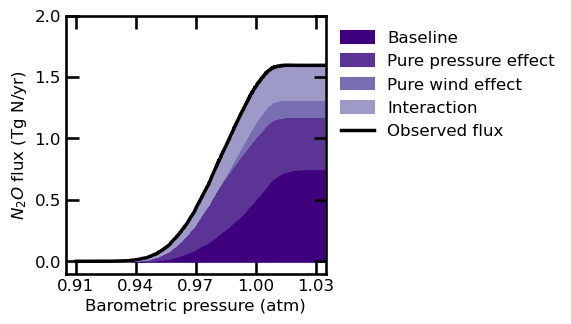

In [24]:
# Pure effects (no interaction)
data_sorted = pd.read_csv("datasets/fig3.csv")
pure_wind_effect = data_sorted.Ft_cumulative1atm - data_sorted.Ft_cumulativebaseline
pure_pressure_effect = data_sorted.Ft_cumulativemedK - data_sorted.Ft_cumulativebaseline
interaction_continuous = data_sorted.Ft_cumulativeobserved - data_sorted.Ft_cumulativemedK - data_sorted.Ft_cumulative1atm + data_sorted.Ft_cumulativebaseline

# Stacked plot
cmap = plt.get_cmap('Purples')
colors = cmap(np.linspace(0.5, 1.0, len(conditions)))

fig, ax = plt.subplots(1,1, figsize = (3.35, 3.35))
ax.fill_between(mslarray, 
                0, data_sorted.Ft_cumulativebaseline,
color = colors[3],
                label="Baseline")
ax.fill_between(mslarray, 
                data_sorted.Ft_cumulativebaseline, 
                data_sorted.Ft_cumulativebaseline + pure_pressure_effect,
color = colors[2],
                label="Pure pressure effect")
ax.fill_between(mslarray, 
                data_sorted.Ft_cumulativebaseline + pure_pressure_effect, 
                data_sorted.Ft_cumulativebaseline + pure_pressure_effect + pure_wind_effect,
color = colors[1],
                label="Pure wind effect")
ax.fill_between(mslarray, 
                data_sorted.Ft_cumulativebaseline + pure_pressure_effect + pure_wind_effect, 
                data_sorted.Ft_cumulativebaseline + pure_pressure_effect + pure_wind_effect + interaction_continuous,
color = colors[0],
                label="Interaction")
ax.plot(mslarray,
        np.array(data_sorted.Ft_cumulativeobserved), 'k-', label="Observed flux")
ax.legend(framealpha = 0, bbox_to_anchor=(1.0,1.0), loc = "upper left", fontsize = 12)
ax.set_ylabel(r"$N_2O$ flux (Tg N/yr)", fontsize = 12)
ax.set_xlabel("Barometric pressure (atm)", fontsize = 12)
ax.set_xlim([0.905, 1.035])
ax.set_ylim([-0.1, 2.0])
ax.set_xticks(np.linspace(0.91, 1.03, 5))
#ax.set_yticks([0, 0.5, 1.0, 1.5, 2.0])
ax.tick_params(direction="in", top = True, right = True, labelsize=12)
#ax.set_title(windproduct)

plt.savefig("figures/figure3.pdf", bbox_inches = "tight")

plt.show()

# FIGURE 4

In [27]:
conditions = ["1atm", "medK", "medN2O", "observed", "noice", "WINDS", "COMBINED"]
monthlycolumns = ['zone', 'month']
seasonalcolumns = ['zone', 'season']
annualcolumns = ['month']
zonalcolumns = ['zone']

wind_uncertainties_monthly = []
wind_uncertainties_annual = []
wind_uncertainties_seasonal = []
wind_uncertainties_zonal = []

annual = data.copy()
seasonarray = np.copy(np.array(data.zone))
seasonarray[np.isin(annual.month, [4,5,6])] = 'peak'
seasonarray[np.isin(annual.month, [10,11,12])] = 'trough'
seasonarray[np.isin(annual.month, [1,2,3,7,8,9])] = 'none'
annual['season'] = seasonarray
annual["doy"] = np.array([pd.Timestamp(d).dayofyear for d in annual.loc[:,'JULD'].values])

for i, condition in enumerate(conditions):
    inputs = generateinputs([condition], ["ncep", "era5"])
    monthlylabels = ['zone', 'month']
    seasonallabels = ['zone', 'season']
    annuallabels = ['month']
    zonallabels = ['zone']
    
    for test in inputs:
        p = test[0]
        w = test[1]
        t = test[2]
        
        Ft = np.load(f"{outputpath}/fluxtests/{t}{w}{p}_mean.npy")
        
        meanlabel = f"{t}{w}{p}"
        for lst in [monthlylabels, seasonallabels, annuallabels, zonallabels]:
            lst.append(meanlabel)

        annual[meanlabel] = Ft*annual.m2*annual.daysinmonth/annual.msl_era5count*(Ngpermol*2)/Tgperg/umolpermol

    wind_uncertainty = np.array(annual[monthlylabels].groupby(['zone','month']).sum().std(axis = 1))
    wind_uncertainties_monthly.append(wind_uncertainty)

    wind_uncertainty = np.array(annual[annuallabels].groupby('month').sum().std(axis = 1))
    wind_uncertainties_annual.append(wind_uncertainty)

    wind_uncertainty = np.array(annual[seasonallabels].groupby(['zone','season']).sum().std(axis = 1))*4
    wind_uncertainties_seasonal.append(wind_uncertainty)

    wind_uncertainty = np.array(annual[zonallabels].groupby('zone').sum().std(axis = 1))
    wind_uncertainties_zonal.append(wind_uncertainty)
    
    annual[f"mean_flux{condition}"] = np.load(f'{outputpath}/fluxtests/{condition}combined_mean.npy')*annual.m2*annual.daysinmonth/annual.msl_era5count*(Ngpermol*2)/Tgperg/umolpermol
    annual[f"montecarlo_uncertainty{condition}"] = np.load(f'{outputpath}/fluxtests/{condition}combined_stdev.npy')*annual.m2*annual.daysinmonth/annual.msl_era5count*(Ngpermol*2)/Tgperg/umolpermol
    annual[f"montecarlo_uncertainty_squared{condition}"] = annual[f"montecarlo_uncertainty{condition}"]**2

    for lst in [monthlycolumns, seasonalcolumns, annualcolumns, zonalcolumns]:
        lst.append(f"mean_flux{condition}")
        lst.append(f"montecarlo_uncertainty_squared{condition}")

grouped = annual[monthlycolumns].groupby(['zone','month']).sum()

for i, condition in enumerate(conditions):
    grouped[f"wind_uncertainty{condition}"] = wind_uncertainties_monthly[i]
    grouped[f"bootstrap_uncertainty{condition}"] = 0.0385*grouped[f"mean_flux{condition}"]
    grouped[f"total_uncertainty{condition}"] = np.sqrt(grouped[f"montecarlo_uncertainty_squared{condition}"] + 
                                                       grouped[f"wind_uncertainty{condition}"]**2 +
                                                       grouped[f"bootstrap_uncertainty{condition}"]**2)

overall = annual[annualcolumns].groupby(['month']).sum()

for i, condition in enumerate(conditions):
    overall[f"wind_uncertainty{condition}"] = wind_uncertainties_annual[i]
    overall[f"bootstrap_uncertainty{condition}"] = 0.0385*overall[f"mean_flux{condition}"]
    overall[f"total_uncertainty{condition}"] = np.sqrt(overall[f"montecarlo_uncertainty_squared{condition}"] + 
                                                       overall[f"wind_uncertainty{condition}"]**2 +
                                                       overall[f"bootstrap_uncertainty{condition}"]**2)

overall.to_csv("datasets/fig4.csv")

inputs: [['W14', 'ncep', '1atm'], ['W14', 'era5', '1atm'], ['L13', 'ncep', '1atm'], ['L13', 'era5', '1atm']]
inputs: [['W14', 'ncep', 'medK'], ['W14', 'era5', 'medK'], ['L13', 'ncep', 'medK'], ['L13', 'era5', 'medK']]
inputs: [['W14', 'ncep', 'medN2O'], ['W14', 'era5', 'medN2O'], ['L13', 'ncep', 'medN2O'], ['L13', 'era5', 'medN2O']]
inputs: [['W14', 'ncep', 'observed'], ['W14', 'era5', 'observed'], ['L13', 'ncep', 'observed'], ['L13', 'era5', 'observed']]
inputs: [['W14', 'ncep', 'noice'], ['W14', 'era5', 'noice'], ['L13', 'ncep', 'noice'], ['L13', 'era5', 'noice']]
inputs: [['W14', 'ncep', 'WINDS'], ['W14', 'era5', 'WINDS'], ['L13', 'ncep', 'WINDS'], ['L13', 'era5', 'WINDS']]
inputs: [['W14', 'ncep', 'COMBINED'], ['W14', 'era5', 'COMBINED'], ['L13', 'ncep', 'COMBINED'], ['L13', 'era5', 'COMBINED']]


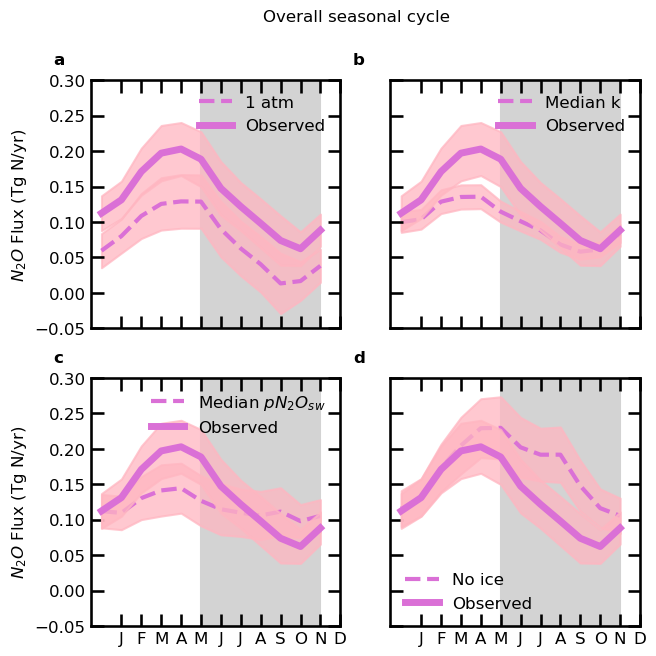

In [28]:
overall = pd.read_csv("datasets/fig4.csv")
cmap = plt.get_cmap('tab20c')
colors = cmap(np.linspace(0, 1, 10))
numeric_months = [1,2,3,4,5,6,7,8,9,10,11,12]

fillcolors = [colors[3],
              colors[1],
              colors[9]]

linecolors = [colors[2],
             colors[0],
             'k']

tests = ["1atm", "medK", "medN2O", "noice"]
labels = [
          "1 atm",
    "Median k",
          "Median $pN_2O_{sw}$",
         "No ice"]

linewidths = [3,3,3,1]
linestyles = ["-","--","--","-"]
subplotlabels = ["a", "b", "c", "d"]

fig, axes = plt.subplots(2,2, sharex = True, sharey=True, figsize = (7.09,7.09))

for i, test in enumerate(tests):
    ax = axes[i//2,i%2]
    ax.axvspan(5,11,color="lightgray", zorder=0)
    
    ax.fill_between(np.array(overall.index),
                    np.array(overall[f"mean_flux{test}"]-overall[f"total_uncertainty{test}"]),
                    np.array(overall[f"mean_flux{test}"]+overall[f"total_uncertainty{test}"]),
                    color = "lightpink",
                    alpha = 0.75, zorder=i, label = None)
    ax.plot(np.array(overall.index),
                    np.array(overall[f"mean_flux{test}"]), linewidth = 3,
            color = "orchid", zorder = i,
            linestyle = "--", label = labels[i])
    ax.fill_between(np.array(overall.index),
                    np.array(overall[f"mean_fluxobserved"]-overall[f"total_uncertaintyobserved"]),
                    np.array(overall[f"mean_fluxobserved"]+overall[f"total_uncertaintyobserved"]),
                    color = "lightpink",
                    alpha = 0.75, zorder=i, label = None)
    ax.plot(np.array(overall.index),
                    np.array(overall[f"mean_fluxobserved"]), linewidth = 5,
            color = "orchid", zorder = i,
            label = "Observed")
    ax.text(-0.15, 1.05, subplotlabels[i], fontweight="bold",
        horizontalalignment = "left",
        verticalalignment = "bottom",
        transform = ax.transAxes,
           fontsize = 12)

    ax.legend(fontsize = 12, framealpha = 0)
    #ax.set_title(labels[i], fontsize = 12)
    ax.set_ylim([-0.05, 0.3])
    ax.set_xticks(numeric_months)
    ax.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"],
                      fontsize = 12)
    if i%2 == 0:
        ax.set_ylabel("$N_2O$ Flux (Tg N/yr)", fontsize = 12)
    ax.tick_params(direction="in", top = True, right=True, labelsize = 12)

fig.suptitle("Overall seasonal cycle", fontsize = 12)

plt.savefig("figures/figure4.pdf", bbox_inches = "tight")

plt.show()

# FIGURE 5

In [29]:
monthlyzonalmeans = data[["zone", "month", "DpN2O_pred", "DpN2O_pred2", "DpN2O_pred3"]].groupby(["zone", "month"]).mean()
monthlyzonalstds = data[["zone", "month", "DpN2O_pred", "DpN2O_pred2", "DpN2O_pred3"]].groupby(["zone", "month"]).std()
monthlyzonalcounts = data[["zone", "month", "DpN2O_pred", "DpN2O_pred2", "DpN2O_pred3"]].groupby(["zone", "month"]).count()
monthlyzonalmeans = monthlyzonalmeans.join(monthlyzonalstds, rsuffix = "_std")
monthlyzonalmeans = monthlyzonalmeans.join(monthlyzonalcounts, rsuffix = "_count")
monthlyzonalmeans['DpN2O_pred_sem'] = monthlyzonalmeans['DpN2O_pred_std']/np.sqrt(monthlyzonalmeans.DpN2O_pred_count)
monthlyzonalmeans['DpN2O_pred2_sem'] = monthlyzonalmeans['DpN2O_pred2_std']/np.sqrt(monthlyzonalmeans.DpN2O_pred2_count)
monthlyzonalmeans['DpN2O_pred3_sem'] = monthlyzonalmeans['DpN2O_pred3_std']/np.sqrt(monthlyzonalmeans.DpN2O_pred3_count)

monthlyzonalmeans.to_csv('datasets/fig5.csv')

KeyError: 'STZ'

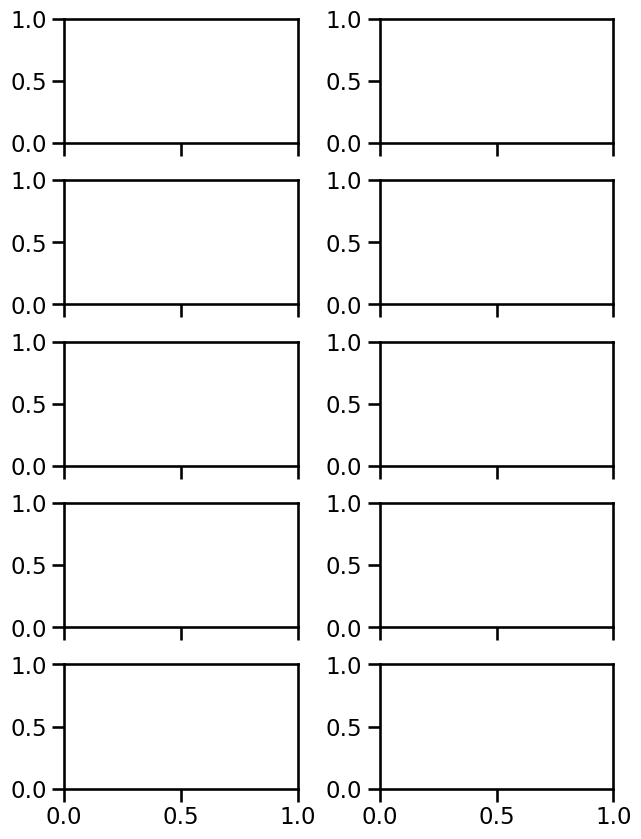

In [31]:
monthlyzonalmeans = pd.read_csv('datasets/fig5.csv')
numeric_months = [1,2,3,4,5,6,7,8,9,10,11,12]
zones = ["STZ", "SAZ","PFZ","ASZ","SIZ"]
zonecolors = ['C2', 'C3', 'royalblue', 'orange','mediumpurple']
fillcolors = ["lightgreen","lightpink","lightblue","bisque","thistle"]
zonelabels = ["STZ", "SAZ","PFZ","ASZ","SIZ"]
plotlabels = ["a","c","e","g","i",]
plotlabels2 = ["b","d", "f", "h", "j"]

fig, axes = plt.subplots(5,2, figsize = (7.09,10), sharex=True, sharey=False)
fig.subplots_adjust(wspace = 0.35, hspace = 0.3)
for i in range(5):
    ax = axes[i, 0]
    zone = zones[i]
    temp = monthlyzonalmeans.loc[zone]


    ax.axvspan(5,11,color="lightgray", zorder=0)
    ax.fill_between(numeric_months, temp.DpN2O_pred - temp.DpN2O_pred_sem, temp.DpN2O_pred + temp.DpN2O_pred_sem,
                    color = fillcolors[i], zorder=1,alpha=0.5)
    ax.plot(numeric_months, temp.DpN2O_pred,
           color = zonecolors[i], zorder=2, linewidth = 5, label = "real $\Delta pN_2O$")
    
    ax.fill_between(numeric_months, temp.DpN2O_pred2 - temp.DpN2O_pred2_sem, temp.DpN2O_pred2 + temp.DpN2O_pred2_sem,
                    color = fillcolors[i], zorder=1,alpha=0.5)
    ax.plot(numeric_months, temp.DpN2O_pred2,
           color = zonecolors[i], zorder=2, linestyle = "--",
           label = "1 atm")
    
    if i==4:
        ax.set_ylim([-10,50])
        ax.set_yticks([0,20,40])
    #else:
        #ax.set_ylim([-12, 25])
        #ax.set_yticks([-10,0,10,20])

    ax.text(-0.15, 1.05, plotlabels[i], fontweight="bold",
            horizontalalignment = "left",
            verticalalignment = "bottom",
            transform = ax.transAxes,
           fontsize = 12)
    ax.set_xticks(numeric_months)
    ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
                      fontsize = 12)
    ax.set_ylabel("$\Delta pN_2O$ (natm)", fontsize = 12)
    ax.tick_params(direction = "in", top=True, right=True, labelsize = 12)
    ax.set_title(zone, fontsize = 12)

for i in range(5):
    ax = axes[i,1]
    zone = zones[i]
    temp = grouped.loc[zone]

    ax.axvspan(5,11,color="lightgray", zorder=0)
    
    ax.fill_between(numeric_months,
                    np.array(temp.mean_fluxobserved-temp.total_uncertaintyobserved),
                    np.array(temp.mean_fluxobserved+temp.total_uncertaintyobserved),
                    color = fillcolors[i], zorder=1,alpha=0.5)
    ax.plot(numeric_months, np.array(temp.mean_fluxobserved), color = zonecolors[i], zorder=2, linewidth = 5,
           label = "Observed")
    
    ax.fill_between(numeric_months,
                    np.array(temp.mean_flux1atm-temp.total_uncertainty1atm),
                    np.array(temp.mean_flux1atm+temp.total_uncertainty1atm),
                    color = fillcolors[i], zorder=1,alpha=0.5)
    ax.plot(numeric_months, np.array(temp.mean_flux1atm), color = zonecolors[i], zorder=2, linestyle = "--",
           label = "1 atm")
    '''
    ax.fill_between(numeric_months,
                    np.array(temp.mean_fluxmedK-temp.total_uncertaintymedK),
                    np.array(temp.mean_fluxmedK+temp.total_uncertaintymedK),
                    color = fillcolors[i], zorder=1,alpha=0.5)
    ax.plot(numeric_months, np.array(temp.mean_fluxmedK), color = zonecolors[i], zorder=2, linestyle = "--",
           label = "Med. k")  
    '''
    ax.fill_between(numeric_months,
                np.array(temp.mean_fluxnoice-temp.total_uncertaintynoice),
                np.array(temp.mean_fluxnoice+temp.total_uncertaintynoice),
                color = fillcolors[i], zorder=1,alpha=0.5)
    ax.plot(numeric_months, np.array(temp.mean_fluxnoice), color = zonecolors[i], zorder=3, linewidth = 1,
           label = "no ice")

    ax.set_xticks(numeric_months)
    ax.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"],#["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
                      )
    if i==0:
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize = 12, framealpha = 0)#,title="Sensitivity test", 
    if i==4: 
        ax.set_ylim([-0.015, 0.12])
        ax.set_yticks([0,0.05,0.1])
    #else:
        #ax.set_ylim([-0.015, 0.08])
        #ax.set_yticks([0,0.03,0.06])
    
    ax.tick_params(direction = "in", top=True, right=True, labelsize = 12)
    ax.text(-0.15, 1.05, plotlabels2[i], fontweight="bold",
        horizontalalignment = "left",
        verticalalignment = "bottom",
        transform = ax.transAxes,
           fontsize = 12)    
    ax.set_ylabel("Flux (Tg N/yr)", fontsize = 12)
    ax.set_title(zone, fontsize = 12)

plt.savefig("figures/figure5.pdf", bbox_inches = "tight")

plt.show()